## Decision Tree

In [1]:
# working with dataset with same feature name, add 1 or 2 to the feature name
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#dataset on human acitivity, labels from 1-6 defining different actions
def get_human_dataset():
    
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                                 header = None, names = ['column_index', 'column_name'])

    feature_name = get_new_feature_name_df(feature_name_df)
    feature_name = feature_name.iloc[:, 1].values.tolist()
    
    
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', header = None, names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', header = None, names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header = None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header = None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [4]:
# get distribution of the label
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [5]:
#check for null value
X_train.isna().sum().sum()

0

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# DecisionTree Classifier
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

print(dt_clf.get_params)

0.8547675602307431
<bound method BaseEstimator.get_params of DecisionTreeClassifier(random_state=156)>


In [15]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth' : [6,8,10,12,16,20,24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose = 1 )
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.7min finished


0.8525571273122959
{'max_depth': 8}


In [16]:
# get results into dataframe
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.810650,0.027159,0.001795,0.002221,6,{'max_depth': 6},0.814111,0.873555,0.819728,0.865895,0.881471,0.850925,0.028282,4
1,2.283845,0.081116,0.003124,0.006248,8,{'max_depth': 8},0.820896,0.827328,0.855102,0.868618,0.891008,0.852557,0.026007,1
2,2.699171,0.084656,0.003125,0.006249,10,{'max_depth': 10},0.799864,0.813052,0.863265,0.891082,0.887602,0.850925,0.037828,4
3,2.979749,0.096884,0.002799,0.002397,12,{'max_depth': 12},0.795115,0.813052,0.848980,0.877468,0.886240,0.844124,0.035436,7
4,3.599153,0.534435,0.007979,0.006525,16,{'max_depth': 16},0.799864,0.822570,0.853061,0.887679,0.897820,0.852149,0.037310,2
5,3.583095,0.321279,0.004188,0.002221,20,{'max_depth': 20},0.803256,0.822570,0.856463,0.877468,0.898501,0.851605,0.034855,3
6,3.623265,0.327597,0.006135,0.004839,24,{'max_depth': 24},0.796472,0.822570,0.856463,0.877468,0.898501,0.850245,0.036793,6


In [18]:
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850925
1,8,0.852557
2,10,0.850925
3,12,0.844124
4,16,0.852149
5,20,0.851605
6,24,0.850245


In [20]:
# can also try out different parameters using loop
max_depth = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depth:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} accuracy: {1:.4f}'.format(depth, accuracy))

max_depth = 6 accuracy: 0.8558
max_depth = 8 accuracy: 0.8707
max_depth = 10 accuracy: 0.8673
max_depth = 12 accuracy: 0.8646
max_depth = 16 accuracy: 0.8575
max_depth = 20 accuracy: 0.8548
max_depth = 24 accuracy: 0.8548


In [21]:
from sklearn.model_selection import GridSearchCV

# checking multiple parameters on GridSearchCV
params = { 'max_depth' : [6,8,10,12,16,20,24],
         'min_samples_split' : [16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose = 1 )
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  3.3min finished


0.8550054406964092
{'max_depth': 8, 'min_samples_split': 16}


In [23]:
# use best paramedter to predict
best_df_clf = grid_cv.best_estimator_

pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print(accuracy)

0.8717339667458432


In [24]:
X_train.head(10)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
5,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,0.019953,-0.545410,-0.844619,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126
6,0.279454,-0.019641,-0.110022,-0.996921,-0.967186,-0.983118,-0.997003,-0.966097,-0.983116,-0.940987,...,0.145844,-0.217198,-0.564430,-0.212754,-0.230622,0.014637,-0.189512,-0.852150,0.182170,-0.043010
7,0.277432,-0.030488,-0.125360,-0.996559,-0.966728,-0.981585,-0.996485,-0.966313,-0.982982,-0.940987,...,0.136382,-0.082307,-0.421715,-0.020888,0.593996,-0.561871,0.467383,-0.851017,0.183779,-0.041976
8,0.277293,-0.021751,-0.120751,-0.997328,-0.961245,-0.983672,-0.997596,-0.957236,-0.984379,-0.940598,...,0.314038,-0.269401,-0.572995,0.012954,0.080936,-0.234313,0.117797,-0.847971,0.188982,-0.037364
9,0.280586,-0.009960,-0.106065,-0.994803,-0.972758,-0.986244,-0.995405,-0.973663,-0.985642,-0.940028,...,0.267383,0.339526,0.140452,-0.020590,-0.127730,-0.482871,-0.070670,-0.848294,0.190310,-0.034417


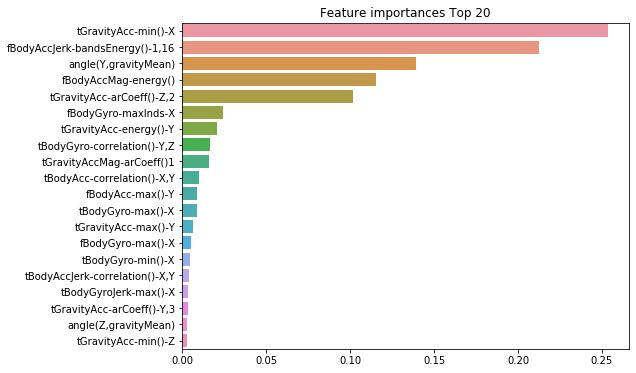

In [26]:
import seaborn as sns

#use feature importance to plot FI for each feature
ftr_importances_values = best_df_clf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## Ensemble Learning

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# load two classifiers, Logit and KNN
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 8)

vo_clf = VotingClassifier( estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

# use weighted average of two probabilities to predict
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

# ensemble methods gets a little more accruate score
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} accuracy: {1:.4f}' .format(class_name, accuracy_score(y_test, pred)))

0.956140350877193
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


C:\Users\DooDoo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\DooDoo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## RandomForest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('random forest accuracy: {0: .4f}'.format(accuracy))

random forest accuracy:  0.9108


In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

#n_jobs=-1 means use all cores
rf_clf = RandomForestClassifier(random_state =0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs =-1 )
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.9166213275299239


## GBM Classifier

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM accuracy: {0:.4f}'.format(gb_accuracy))
print('GBM time taken: {0:.1f}'.format(time.time() - start_time))


GBM accuracy: 0.9386
GBM time taken: 193.1


In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('best hyperparameter:\n', grid_cv.best_params_)
print('best predicted accuracy: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 17.6min finished


best hyperparameter:
 {'learning_rate': 0.05, 'n_estimators': 500}
best predicted accuracy: 0.9014


In [13]:
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM accuracy: {0:.4f}'.format(gb_accuracy))

GBM accuracy: 0.9396


In [14]:
len(X_train)

7352